This project aims to detect land cover changes over time using Sentinel-2 satellite imagery. The analysis focuses on identifying urban expansion and deforestation using image segmentation techniques




*   Urbanization and deforestation significantly impact climate change, biodiversity, and resource management.
*   Sentinel-2 provides multi-spectral imaging with high spatial resolution, making it suitable for tracking land cover changes.
* Automating this process can help governments, urban planners, and environmental organizations make data-driven decisions.





# **Step 1:** *Collect Sentinel-2 Satellite Images ad preprocessing*

In [2]:
import ee
import geemap
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Initialize the Earth Engine module
ee.Authenticate()
ee.Initialize(project='sound-essence-295918')
print("Google Earth Engine is successfully initialized!")



Google Earth Engine is successfully initialized!


In [4]:
# Define the bounding box for Veneto
veneto_bbox = ee.Geometry.Rectangle([10.9399, 44.7739, 12.6648, 46.5682])

In [5]:
# Center the map on the ROI
Map = geemap.Map()
Map.centerObject(veneto_bbox, 8)  # Zoom level 8 for regional view

In [6]:
# Add the ROI to the map
Map.addLayer(veneto_bbox, {'color': 'red'}, 'Veneto Region')
Map

Map(center=[45.669499615461646, 11.80234999999995], controls=(WidgetControl(options=['position', 'transparent_…

Displays the Sentinel-2 image in true color (Red, Green, Blue).Enhances contrast with a <code>gamma</code>value.

In [7]:
# Define the time range for the satellite images
start_date_2020 = '2020-01-01'
end_date_2020 = '2020-12-31'

# Load Sentinel-2 Image Collection for the Veneto region
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(veneto_bbox) \
    .filterDate(start_date_2020, end_date_2020) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Keep images with <10% cloud cover(Filter to metadata less than the given value)

# Reduces an image collection by calculating the median of all values at each pixel across the stack of all matching bands.
median_image_2020 = sentinel2.median().clip(veneto_bbox)

# Print image information
print(median_image_2020.getInfo())




{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'dimensions': [4, 4], 'origin': [10, 44], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'dimensions': [4, 4], 'origin': [10, 44], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'dimensions': [4, 4], 'origin': [10, 44], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'dimensions': [4, 4], 'origin': [10, 44], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'dimensions': [4, 4], 'origin': [10, 44], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 

In [8]:
# Visualization parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # Red-Green-Blue bands for natural color
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Add Sentinel-2 image to the interactive map
Map.addLayer(median_image_2020, vis_params, 'Sentinel-2 Image')
Map


Map(center=[45.669499615461646, 11.80234999999995], controls=(WidgetControl(options=['position', 'transparent_…

In [9]:
# Define the time range for 2016
start_date_2016 = '2016-01-01'  # Sentinel-2 became operational in mid-2016
end_date_2016 = '2016-12-31'

# Load Sentinel-2 images for 2016
sentinel2_2016 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(veneto_bbox) \
    .filterDate(start_date_2016, end_date_2016) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Remove cloudy images

# Compute the median image for 2016
median_image_2016 = sentinel2_2016.median().clip(veneto_bbox)

# Define visualization parameters for true-color images
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # Red-Green-Blue for natural color
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Add 2016 and 2020 images to the map
Map.addLayer(median_image_2016, vis_params, 'Sentinel-2 2016')
Map.addLayer(median_image_2020, vis_params, 'Sentinel-2 2020')

# Show the map
Map


Map(center=[45.669499615461646, 11.80234999999995], controls=(WidgetControl(options=['position', 'transparent_…

# **Step 2:** *Apply Image Segmentation (Change Detection)*

In the following map urban expansion and deforestation can be observed clearly in red-band differences. Red reflectance is sensitive to vegetation and soil changes.

* Blue → Decreased reflectance (Vegetation loss).



* White → No change.

* Red → Increased reflectance (Urban expansion).




In [10]:
# Compute the difference between 2020 and 2016 (Red Band)
change_detection = median_image_2020.select('B4').subtract(median_image_2016.select('B4'))

# Visualization parameters (Highlighting changes)
change_vis_params = {
    'min': -500,
    'max': 500,
    'palette': ['blue', 'white', 'red']  # Blue = decrease, White = no change, Red = increase
}

# Add change detection layer to the map
Map.addLayer(change_detection, change_vis_params, 'Change Detection (2016-2023)')
Map


Map(center=[45.669499615461646, 11.80234999999995], controls=(WidgetControl(options=['position', 'transparent_…

# **Step 5**: *Land Cover Classification*

Manually define example points in the region that represent different land types.

In [11]:
# Define sample points for Urban Areas
urban = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([11.877, 45.403]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([11.883, 45.407]), {'class': 0}),
])  # Class 0 = Urban

# Define sample points for Vegetation
vegetation = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([11.937, 45.326]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([11.943, 45.321]), {'class': 1}),
])  # Class 1 = Vegetation

# Define sample points for Water Bodies
water = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([12.301, 45.432]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([12.311, 45.429]), {'class': 2}),
])  # Class 2 = Water

# Define sample points for Barren Land
barren = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([11.735, 45.275]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([11.740, 45.270]), {'class': 3}),
])  # Class 3 = Barren Land

# Merge all classes into one dataset
training_samples = urban.merge(vegetation).merge(water).merge(barren)


**Extract Features from Sentinel-2**

In [12]:
# Select Sentinel-2 spectral bands relevant for classification
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']  # Blue, Green, Red, NIR, SWIR1, SWIR2

# Sample training data from Sentinel-2 image
training_data = median_image_2020.select(bands).sampleRegions(
    collection=training_samples,
    properties=['class'],
    scale=30  # Resolution in meters
)

# Print the number of training samples
print("Number of training samples:", training_data.size().getInfo())


Number of training samples: 8


**Train a Machine Learning Model (Random Forest)**

In [13]:
# Train the classifier using Random Forest with 50 trees
classifier = ee.Classifier.smileRandomForest(50).train(
    features=training_data,
    classProperty='class',
    inputProperties=bands
)

# Apply classification to the entire Veneto region
classified_image = median_image_2020.select(bands).classify(classifier)


# **Step 5:** *Visualize and Compare Changes*

**Visualize the Classified Land Cover Map**

In [14]:
# Define visualization parameters
class_vis = {
    'min': 0,
    'max': 3,
    'palette': ['red', 'green', 'blue', 'gray']  # Urban, Vegetation, Water, Barren
}

# Add classification result to the map
Map.addLayer(classified_image, class_vis, 'Land Cover Classification')
Map


Map(center=[45.669499615461646, 11.80234999999995], controls=(WidgetControl(options=['position', 'transparent_…

In [15]:

# Load Sentinel-2 images for 2015
sentinel2_2016 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(veneto_bbox) \
    .filterDate('2016-01-01', '2016-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .limit(10)
    # Allow 20% cloud cover and limits to 10 images to reduce memory usage

# Count the number of available images
image_count_2016 = sentinel2_2016.size().getInfo()
print("Number of Sentinel-2 images in 2016:", image_count_2016)


Number of Sentinel-2 images in 2016: 10


This is a classified land cover map for 2015

In [16]:
# Applies the trained Random Forest classifier to 2016 images.
classified_image_2016 = median_image_2016.select(bands).classify(classifier)

# Visualize 2016 land cover classification
Map.addLayer(classified_image_2016, class_vis, 'Land Cover 2016')
Map


Map(center=[45.669499615461646, 11.80234999999995], controls=(WidgetControl(options=['position', 'transparent_…

**How to Interpret The following map:**

> 🔴 Red = Urban Expansion (newly developed areas)
---
> 🟢 Green = Vegetation Increase (forestation, regrowth)
---
> 🔵 Blue = Water Body Changes (drying lakes/rivers or new water bodies)
---
> ⚪ Gray = No Change


## Analyzing Land Cover Changes (2016-2023)

In [17]:
# Compute land cover changes
land_change = classified_image.subtract(classified_image_2016)

# Define visualization for changes
change_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'green', 'blue']  # Urban, Vegetation, Water
}

# Add land cover changes to the map
Map.addLayer(land_change, change_vis_params, 'Land Cover Changes(2016-2020)')

Map

Map(center=[45.669499615461646, 11.80234999999995], controls=(WidgetControl(options=['position', 'transparent_…

Defines color representation for land changes:
* Red → Urban Expansion (e.g., new buildings).
* Green → Vegetation Growth (e.g., reforestation).
* Blue → Water Body Changes (e.g., drying lakes/rivers)

**Quantify the Changes**\
This calculates the total area (in square meters) for each land cover change

In [18]:
# Define land cover change categories
urban_expansion = land_change.eq(1)  # Areas changed to urban
vegetation_loss = land_change.eq(-1) # Areas that lost vegetation
water_change = land_change.eq(2)     # Areas that changed to water

THe code below gets the area of each pixel (<code>ee.Image.pixelArea()</code>).
Multiplies each change mask by pixel area.
Summarizes the total area in square meters using <code>reduceRegion()</code>.
Prints the final area for each change category

In [19]:
# Function to calculate area in square meters
def calculate_area(change_mask, name):
    pixel_area = ee.Image.pixelArea()  # Get the area of each pixel in m²
    change_area = change_mask.multiply(pixel_area)  # Multiply mask by pixel area
    area_sum = change_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=veneto_bbox,
        scale=100,  # Sentinel-2 resolution is 100m
        maxPixels=1e9
    )
    print(f"Total {name} area (m²):", area_sum.getInfo())

# Compute area for each land cover change type
calculate_area(urban_expansion, "Urban Expansion")
calculate_area(vegetation_loss, "Vegetation Loss")
calculate_area(water_change, "Water Body Change")

Total Urban Expansion area (m²): {'classification': 959595886.5889685}
Total Vegetation Loss area (m²): {'classification': 1004844457.5143077}
Total Water Body Change area (m²): {'classification': 461353742.2535979}


# Predict Future Urban Expansion with AI

## Extract Urban Expansion Data from Sentinel-2

   year  urban_area_m2
0  2016   1.086184e+10
1  2017   1.261112e+10
2  2018   1.205612e+10
3  2019   1.243419e+10
4  2020   1.239034e+10
5  2021   1.333525e+10
Predicted Urban Area in 2030 (m²): 13335243776.0


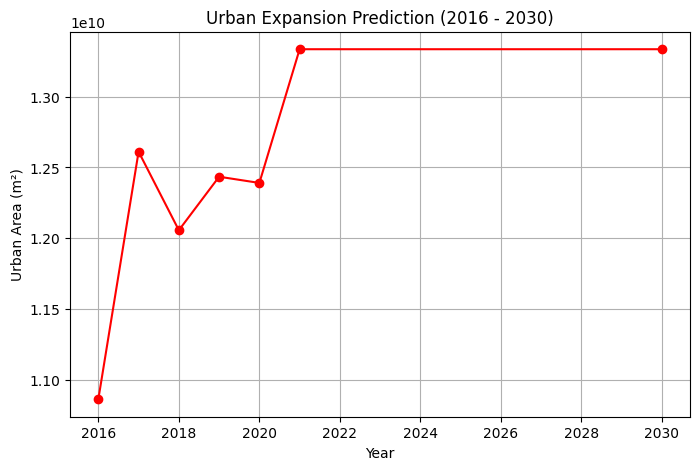

In [20]:


# Define the function to load Sentinel-2 data with band consistency
def load_sentinel(year):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    sentinel = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(veneto_bbox) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
        .select(["B2", "B3", "B4", "B8", "B11", "B12"])  # Keep only common bands

    return sentinel.median().clip(veneto_bbox)  # Compute median image

# Define years to process (2016-2021)
years = list(range(2016, 2022))

# Function to classify urban areas using a Random Forest model
def classify_urban(image):
    classifier = ee.Classifier.smileRandomForest(50).train(
        features=training_data,
        classProperty="class",
        inputProperties=["B2", "B3", "B4", "B8", "B11", "B12"]
    )
    return image.select(["B2", "B3", "B4", "B8", "B11", "B12"]).classify(classifier)

# Extract urban area for each year
def extract_urban_area(year):
    median_image = load_sentinel(year)  # Load median image for the year
    urban_image = classify_urban(median_image)  # Classify urban areas

    # Compute urban area in square meters
    pixel_area = ee.Image.pixelArea()
    urban_pixels = urban_image.eq(1).multiply(pixel_area)  # Mask urban pixels
    total_urban_area = urban_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=veneto_bbox,
        scale=100,  # Use 100m resolution for better efficiency
        maxPixels=1e12
    )

    return ee.Feature(None, {'year': year, 'urban_area_m2': total_urban_area.get('classification')})

# Generate data for all years
urban_area_data = ee.FeatureCollection([extract_urban_area(year) for year in years])

# Convert Earth Engine FeatureCollection to a Pandas DataFrame
urban_features = urban_area_data.getInfo()['features']
urban_data = [{'year': f['properties']['year'], 'urban_area_m2': f['properties']['urban_area_m2']} for f in urban_features]
urban_df = pd.DataFrame(urban_data)

# Display the collected urban area data
print(urban_df)

# Train XGBoost Regression Model
X_train = np.array(urban_df["year"]).reshape(-1, 1)
y_train = np.array(urban_df["urban_area_m2"])

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, objective="reg:squarederror")
model.fit(X_train, y_train)

# Predict urban expansion in 2030
X_future = np.array([[2030]])
predicted_urban_2030 = model.predict(X_future)

print(f"Predicted Urban Area in 2030 (m²): {predicted_urban_2030[0]}")

# Visualize Urban Growth Trends
urban_df.loc[len(urban_df)] = {'year': 2030, 'urban_area_m2': predicted_urban_2030[0]}

plt.figure(figsize=(8, 5))
plt.plot(urban_df["year"], urban_df["urban_area_m2"], marker="o", linestyle="-", color="r")
plt.xlabel("Year")
plt.ylabel("Urban Area (m²)")
plt.title("Urban Expansion Prediction (2016 - 2030)")
plt.grid(True)
plt.show()
